<a href="https://colab.research.google.com/github/Behrad-R/COIN_Notebooks/blob/main/COIN_Seminar_%C3%BCberarbeitet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Coin Seminar Plant Sleep Quality Regression

## Preparation

First of all the required packages need to be installed.

In [ ]:
!pip install timm librosa torch torchvision

Afterwards we will import all the required packages.

In [ ]:
import pandas as pd
import numpy as np
import os
import librosa, librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime

from PIL import Image
import torchaudio
from transformers import ASTFeatureExtractor
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm
import torch.nn as nn
import torch.optim as optim

from google.colab import drive

The notebook will be mounted to google drive to ensure persistent files for all sessions.

In [ ]:
drive.mount("./Drive")

Mounted at ./Drive


We will then select the directory, where all plant recordings and labels are saved.

In [ ]:
%cd /content/Drive/MyDrive/Seminar COINs/COIN Projekt

/content/Drive/MyDrive/Seminar COINs/COIN Projekt


### Helper functions

We will use the following helper function to load and preprocess the audio data. The function will create a tuple of arrays containing the Mel Frequency Cepstral Coefficients, the values for the MEL Spectrograms, the filenames, and the associated subset.

In [ ]:
# Load and preprocess audio data
def load_and_preprocess_data(data_dir, subsets, hop_length=512, n_mels=128):
    """Loads and preprocesses audio data from specified directories.

    Args:
      data_dir: The directory containing the audio data.
      subsets: A list of subdirectories within `data_dir` to load data from.
      hop_length: The hop length to use when computing the Mel spectrogram.
      n_mels: The number of Mel frequency bins to use.

    Returns:
      A tuple containing:
        - A list of Mel spectrograms, one for each audio file.
        - A NumPy array of filenames corresponding to the Mel spectrograms.
        - A list of MFCCs, one for each audio file.
        - A list of subset names corresponding to the Mel spectrograms.
    """
    data = []
    filenames = []
    signals = []
    subset_names = []
    audio_dir = data_dir
    # We iterate through each subset
    for i, subset in enumerate(subsets):
      subset_dir = os.path.join(audio_dir, subset)
      for filename in os.listdir(subset_dir):
        filenames.append(filename) # Saving the filenames in case we need it later
        subset_names.append(subset)
        if filename.endswith('.wav'):
            file_path = os.path.join(subset_dir, filename) # joining the path to the subset and the filename to get the full path
            print(file_path)
            audio_data, sample_rate = librosa.load(file_path, sr=None) # We load the audio data with librosa
            # Perform preprocessing (e.g., convert to Mel spectrogram)
            audio_signal = librosa.feature.mfcc(y=audio_data, sr=sample_rate) # Extracting Mel Frequency Cepstral Coefficients
            mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate, n_mels=n_mels, hop_length=hop_length) # Extracting  Mel spectrogram
            mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max) # We convert the amplitudes to decibel scale
            signals.append(audio_signal)
            data.append(mel_spectrogram)
    return data, np.array(filenames), signals, subset_names

## Loading the data

We will load the labels separately as a Dataframe from the sleep circle data export. It is important to note that the datetime columns "Went to bed" and "Woke up" need to be converted to the datetime with the '%Y-%m-%d %H' format.

In [ ]:
sleep_circle_dir = "./data/Labels/"
sleep_circle_dir

'./data/Labels/'

In [ ]:
sleep_circle_data_list = []
for filename in os.listdir("./data/Labels/"):
  sleep__circle_data = pd.read_csv(os.path.join(sleep_circle_dir, filename), delimiter= ";")
  sleep__circle_data.rename(columns={"Start": "Went to bed", "End": "Woke up"}, inplace = True)
  sleep__circle_data["Went to bed"] = pd.to_datetime(pd.to_datetime(sleep__circle_data["Went to bed"]).dt.strftime('%Y-%m-%d %H'))
  sleep__circle_data["Woke up"] =  pd.to_datetime(pd.to_datetime(sleep__circle_data["Woke up"]).dt.strftime('%Y-%m-%d %H'))
  sleep__circle_data["subset_name"] = filename.split(".csv")[0]
  sleep_circle_data_list.append(sleep__circle_data)
sleep_circle_df = pd.concat(sleep_circle_data_list)
sleep_circle_df

,Went to bed,Woke up,Sleep Quality,Time in bed (seconds),Time asleep (seconds),Asleep after (seconds),Regularity,Did snore,Snore time (seconds),Coughing (per hour),...,Steps,Alarm mode,Air Pressure (Pa),Time before sleep (seconds),Window start,Window stop,Snore time,Weather temperature (°C),Weather type,Notes
0,2024-10-16 03:00:00,2024-10-16 11:00:00,81%,28537.0,25302.0,570.0,—,False,0.0,0.630760,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-10-18 03:00:00,2024-10-18 11:00:00,76%,26734.0,22278.0,1247.0,96%,False,0.0,0.807960,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-10-19 03:00:00,2024-10-19 11:00:00,99%,29337.0,24154.0,586.0,95%,False,0.0,0.613560,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-10-20 03:00:00,2024-10-20 10:00:00,62%,26557.0,22219.0,885.0,94%,False,0.0,0.813345,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-10-21 04:00:00,2024-10-21 11:00:00,55%,27855.0,25626.0,557.0,91%,False,0.0,0.129241,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,2024-11-13 00:00:00,2024-11-13 07:00:00,70%,25146.3,22464.1,NaN,90%,True,NaN,NaN,...,1441.0,No alarm,100.8,502.9,NaN,NaN,5016.9,0.0,No weather,NaN
185,2024-11-15 01:00:00,2024-11-15 07:00:00,50%,23076.2,19922.4,NaN,91%,True,NaN,NaN,...,3179.0,No alarm,100.3,461.5,NaN,NaN,3172.4,0.0,No weather,NaN
186,2024-11-16 23:00:00,2024-11-17 10:00:00,98%,37931.9,30977.7,NaN,66%,True,NaN,NaN,...,2658.0,No alarm,99.0,758.6,NaN,NaN,6113.9,0.0,No weather,NaN
187,2024-11-18 01:00:00,2024-11-18 07:00:00,70%,24901.4,22079.3,NaN,68%,True,NaN,NaN,...,927.0,No alarm,98.4,498.0,NaN,NaN,54.0,0.0,No weather,NaN


In [ ]:
sleep_circle_df["subset_name"].unique()

array(['behrad', 'linus'], dtype=object)

With the helper function we will load and preprocess the plant recordings.

In [ ]:
data_dir = './data/Audio_Data'
subsets = ['behrad', 'linus']
audio_files, filenames, signals, subset_names  = load_and_preprocess_data(data_dir = data_dir, subsets = subsets)

./data/Audio_Data/behrad/behrad_142Hz_1731205560774.wav
./data/Audio_Data/behrad/behrad_142Hz_1731030918106.wav
./data/Audio_Data/behrad/behrad_142Hz_1730861279308.wav
./data/Audio_Data/behrad/behrad_142Hz_1731808947165.wav
./data/Audio_Data/behrad/behrad_142Hz_1731721964748.wav
./data/Audio_Data/behrad/behrad_142Hz_1731639615572.wav
./data/Audio_Data/behrad/behrad_142Hz_1731463744547.wav
./data/Audio_Data/behrad/behrad_142Hz_1731894532622.wav
./data/Audio_Data/behrad/behrad_142Hz_1731290866877.wav
./data/Audio_Data/behrad/behrad_142Hz_1731552619742.wav
./data/Audio_Data/behrad/behrad_142Hz_1731375736354.wav
./data/Audio_Data/behrad/behrad_07-11-2024_02_51_09_142Hz_1730944269321.wav
./data/Audio_Data/behrad/behrad_142Hz_1729904937567.wav
./data/Audio_Data/behrad/behrad_142Hz_1729994749595.wav
./data/Audio_Data/behrad/behrad_142Hz_1730169214846.wav
./data/Audio_Data/behrad/behrad_142Hz_1730341004221.wav
./data/Audio_Data/behrad/behrad_142Hz_1730426561089.wav
./data/Audio_Data/behrad/beh

From the filenames we extract the timestamp and convert it to the same format as the "Went to bed" column from the sleep circle data.

In [ ]:
audio_timestamps = []
for filename in filenames:
  timestamp = filename.split("_")[-1]
  timestamp = timestamp.split(".")[0]
  timestamp = int(timestamp)
  timestamp = datetime.utcfromtimestamp(timestamp/1000).strftime('%Y-%m-%d %H')
  audio_timestamps.append(timestamp)

We join the arrays to a single dataframe for easier use.

In [ ]:
audio_df = pd.DataFrame(data = {"timestamp": audio_timestamps, "mel_spectrogram": audio_files, "mfcc": signals, "filenames": filenames, "subset": subset_names})
audio_df['timestamp'] = pd.to_datetime(audio_df['timestamp'])
audio_df

,timestamp,mel_spectrogram,mfcc,filenames,subset
0,2024-11-10 02:00:00,"[[-3.8146973e-06, -1.6108208, -13.502918, -23....","[[130.01465, 62.54068, -222.61348, -224.39777,...",behrad_142Hz_1731205560774.wav,behrad
1,2024-11-08 01:00:00,"[[-0.30705452, -1.0558624, -2.5947456, -2.6136...","[[-85.283134, -144.85246, -250.27246, -244.692...",behrad_142Hz_1731030918106.wav,behrad
2,2024-11-06 02:00:00,"[[-1.9073486e-06, -0.75629044, -2.191145, -2.0...","[[-87.963745, -145.52042, -236.48047, -239.047...",behrad_142Hz_1730861279308.wav,behrad
3,2024-11-17 02:00:00,"[[-18.497059, -19.10522, -20.147926, -20.61684...","[[-94.037865, -151.36404, -242.62398, -257.627...",behrad_142Hz_1731808947165.wav,behrad
4,2024-11-16 01:00:00,"[[-19.614162, -20.319841, -18.795208, -13.5799...","[[-93.44319, -148.90176, -220.4312, -216.1947,...",behrad_142Hz_1731721964748.wav,behrad
5,2024-11-15 03:00:00,"[[-17.577448, -18.38608, -19.267185, -19.56891...","[[-71.635345, -134.15366, -250.90266, -254.097...",behrad_142Hz_1731639615572.wav,behrad
6,2024-11-13 02:00:00,"[[1.9073486e-06, -0.6920204, -2.118023, -2.044...","[[-87.38878, -146.66676, -247.4006, -248.28622...",behrad_142Hz_1731463744547.wav,behrad
7,2024-11-18 01:00:00,"[[-18.62088, -19.093334, -19.112984, -19.74875...","[[-90.48881, -150.84868, -246.84933, -254.7042...",behrad_142Hz_1731894532622.wav,behrad
8,2024-11-11 02:00:00,"[[0.0, -0.6920223, -2.0632076, -2.225523, -2.2...","[[-88.58623, -147.03284, -244.7393, -244.86621...",behrad_142Hz_1731290866877.wav,behrad
9,2024-11-14 02:00:00,"[[-14.610792, -15.430248, -16.815134, -16.8366...","[[-88.728745, -146.94221, -244.11742, -243.569...",behrad_142Hz_1731552619742.wav,behrad


We will sort the sleep circle data and the plant recording data to merge both dataframe with eachother.

In [ ]:
sleep_circle_df = sleep_circle_df.sort_values("Went to bed")

audio_df = audio_df.sort_values('timestamp')

Because the plant recording starting time and the sleep circle timestamp sometimes do not match to the exact hour, we will merge both dataframes on the "Went to bed" column and the "timestamp" column with a range of 3 hours.

In [ ]:
concat_arr = []
for subset in subsets:
  subset_df = audio_df[audio_df["subset"] == subset]
  sleep_circle_subset_df = sleep_circle_df[sleep_circle_df["subset_name"] == subset]
  subset_merged_df = pd.merge_asof(sleep_circle_subset_df, subset_df, left_on="Went to bed", right_on ="timestamp", direction='nearest', tolerance=pd.Timedelta('3 hour'))
  concat_arr.append(subset_merged_df)
merged_df = pd.concat(concat_arr)

We drop all rows which have null values for the mel_spectrogram. Furthermore we convert the sleep quality column to the float data type ranging from 0 to 1.

In [ ]:
merged_df = merged_df.dropna(subset = ["mel_spectrogram"]).reset_index(drop=True)
merged_df["Sleep Quality"] = merged_df["Sleep Quality"].apply(lambda x: float(x.replace("%", ""))/100)
merged_df

,Went to bed,Woke up,Sleep Quality,Time in bed (seconds),Time asleep (seconds),Asleep after (seconds),Regularity,Did snore,Snore time (seconds),Coughing (per hour),...,Window stop,Snore time,Weather temperature (°C),Weather type,Notes,timestamp,mel_spectrogram,mfcc,filenames,subset
0,2024-10-24 03:00:00,2024-10-24 11:00:00,0.87,28383.0,24504.0,3879.0,93%,False,0.0,0.126836,...,NaN,NaN,NaN,NaN,NaN,2024-10-24 01:00:00,"[[-18.8452, -19.083889, -20.093538, -20.223928...","[[-103.476204, -161.67537, -257.6723, -259.534...",behrad_142Hz_1729733764243.wav,behrad
1,2024-10-26 03:00:00,2024-10-26 10:00:00,0.77,26815.0,24312.0,1877.0,90%,False,0.0,0.671266,...,NaN,NaN,NaN,NaN,NaN,2024-10-26 01:00:00,"[[-9.238922, -9.857189, -11.167709, -11.00028,...","[[-103.459854, -161.75743, -261.34665, -251.59...",behrad_142Hz_1729904937567.wav,behrad
2,2024-10-27 03:00:00,2024-10-27 11:00:00,0.74,30190.0,25460.0,603.0,83%,False,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,2024-10-27 02:00:00,"[[-18.04505, -18.773344, -20.911755, -21.46679...","[[-78.52123, -138.69447, -247.02243, -231.1913...",behrad_142Hz_1729994749595.wav,behrad
3,2024-10-29 03:00:00,2024-10-29 11:00:00,0.80,28575.0,26098.0,2476.0,91%,False,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,2024-10-29 02:00:00,"[[-19.099976, -19.661247, -20.979252, -21.1117...","[[-92.270676, -148.72513, -249.18297, -267.216...",behrad_142Hz_1730169214846.wav,behrad
4,2024-10-31 03:00:00,2024-10-31 10:00:00,0.79,26133.0,23345.0,522.0,92%,False,0.0,0.688784,...,NaN,NaN,NaN,NaN,NaN,2024-10-31 02:00:00,"[[-18.89235, -19.253256, -20.119987, -18.24652...","[[-114.934906, -160.91049, -212.936, -212.7094...",behrad_142Hz_1730341004221.wav,behrad
5,2024-11-01 03:00:00,2024-11-01 09:00:00,0.61,22321.0,17856.0,446.0,90%,False,0.0,0.322566,...,NaN,NaN,NaN,NaN,NaN,2024-11-01 02:00:00,"[[-17.10196, -18.444464, -19.50819, -18.74342,...","[[-88.19196, -137.61987, -199.88036, -203.2071...",behrad_142Hz_1730426561089.wav,behrad
6,2024-11-02 03:00:00,2024-11-02 11:00:00,0.66,27411.0,23756.0,548.0,91%,False,0.0,0.788005,...,NaN,NaN,NaN,NaN,NaN,2024-11-02 02:00:00,"[[-21.891184, -20.23951, -19.505045, -17.7669,...","[[-158.68938, -183.98933, -197.84569, -199.374...",behrad_142Hz_1730513248148.wav,behrad
7,2024-11-03 03:00:00,2024-11-03 09:00:00,0.66,23343.0,19297.0,1478.0,90%,False,0.0,0.154222,...,NaN,NaN,NaN,NaN,NaN,2024-11-03 01:00:00,"[[0.0, -2.5599136, -6.2850456, -8.977453, -10....","[[44.803688, -21.663483, -205.35747, -238.6216...",behrad_142Hz_1730598993365.wav,behrad
8,2024-11-05 02:00:00,2024-11-05 11:00:00,0.84,31618.0,27929.0,1686.0,86%,False,0.0,0.455437,...,NaN,NaN,NaN,NaN,NaN,2024-11-05 01:00:00,"[[-0.21885681, -0.99575615, -2.3791656, -2.375...","[[-86.27451, -144.0646, -235.64583, -238.10379...",behrad_142Hz_1730770930651.wav,behrad
9,2024-11-06 03:00:00,2024-11-06 08:00:00,0.53,17813.0,14903.0,1543.0,74%,False,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,2024-11-06 02:00:00,"[[-1.9073486e-06, -0.75629044, -2.191145, -2.0...","[[-87.963745, -145.52042, -236.48047, -239.047...",behrad_142Hz_1730861279308.wav,behrad


In [ ]:
merged_df.columns

Index(['Went to bed', 'Woke up', 'Sleep Quality', 'Time in bed (seconds)',
       'Time asleep (seconds)', 'Asleep after (seconds)', 'Regularity',
       'Did snore', 'Snore time (seconds)', 'Coughing (per hour)', 'City',
       'Alertness score', 'Alertness reaction time (seconds)',
       'Alertness accuracy', 'Movements per hour', 'Wake up window start',
       'Wake up window stop', 'subset_name', 'Mood', 'Heart rate (bpm)',
       'Steps', 'Alarm mode', 'Air Pressure (Pa)',
       'Time before sleep (seconds)', 'Window start', 'Window stop',
       'Snore time', 'Weather temperature (°C)', 'Weather type', 'Notes',
       'timestamp', 'mel_spectrogram', 'mfcc', 'filenames', 'subset'],
      dtype='object')

## Visualizing the data

In [ ]:
merged_df["mel_spectrogram"][0]

array([[-18.8452  , -19.083889, -20.093538, ..., -19.535164, -19.638866,
        -17.080072],
       [-30.810478, -36.611797, -47.300518, ..., -28.554495, -41.398113,
        -31.19005 ],
       [-34.35653 , -39.929443, -49.219204, ..., -33.824078, -45.942783,
        -35.412598],
       ...,
       [-62.711395, -67.3752  , -71.59468 , ..., -70.90741 , -71.90783 ,
        -64.815094],
       [-63.597607, -69.128296, -74.31559 , ..., -74.79886 , -75.60999 ,
        -64.62386 ],
       [-62.988705, -68.27489 , -75.48656 , ..., -70.947296, -71.73834 ,
        -63.79135 ]], dtype=float32)

In [ ]:
np.abs(merged_df["mfcc"][0])

array([[103.476204 , 161.67537  , 257.6723   , ..., 225.2258   ,
        243.00546  , 115.007996 ],
       [ 66.74364  ,  63.282486 ,  38.202965 , ...,  66.96381  ,
         46.625435 ,  66.636246 ],
       [ 33.111034 ,  32.828316 ,  27.055529 , ...,  51.101723 ,
         34.96334  ,  33.15985  ],
       ...,
       [  4.0009117,   4.740808 ,   8.261148 , ...,   7.952307 ,
         10.983049 ,   5.0698967],
       [  2.8570704,   3.900042 ,   7.613166 , ...,   9.084516 ,
          5.8506885,   4.3412724],
       [  3.4807363,   3.9535072,   5.1084194, ...,   3.0150728,
          4.8416634,   3.6201253]], dtype=float32)

We plot the MEL-Spectrogram and the MFCC with the librosa.display.specshow function (https://librosa.org/doc/main/generated/librosa.display.specshow.html). All values are plotted in hz units but the scale differs (MEL-Spectrogram uses mel scale while MFCC uses hz).

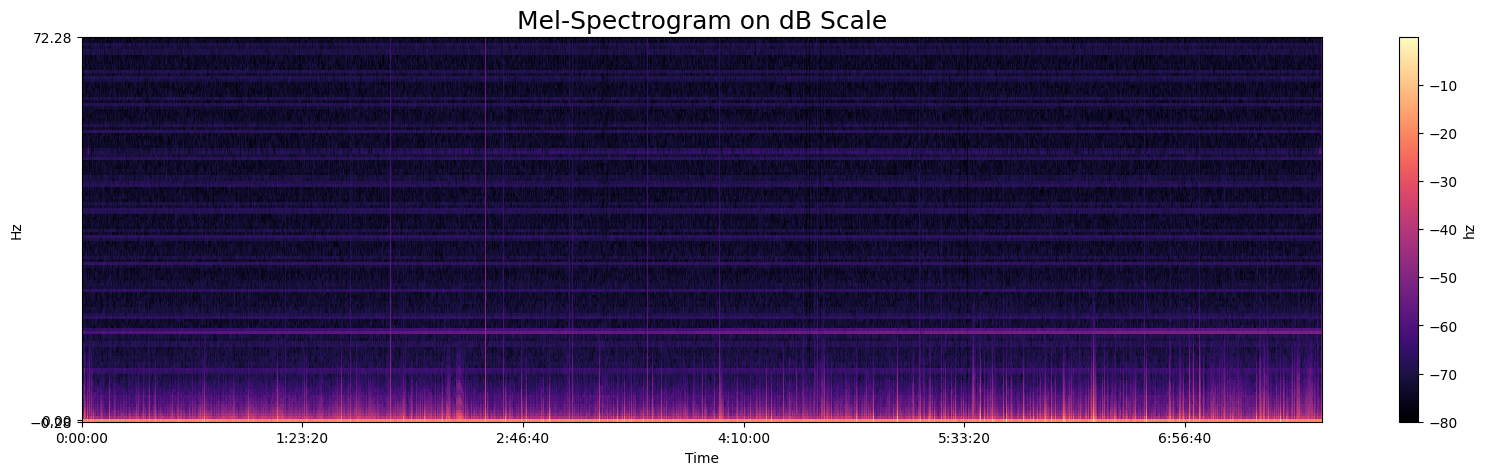

In [ ]:
plt.figure(figsize=(20, 5))
librosa.display.specshow(merged_df["mel_spectrogram"][0], x_axis='time',
                         y_axis='mel', sr=144, cmap= "magma", hop_length=512)
plt.colorbar(label="hz")
plt.title('Mel-Spectrogram on dB Scale', fontdict=dict(size=18))
plt.show()

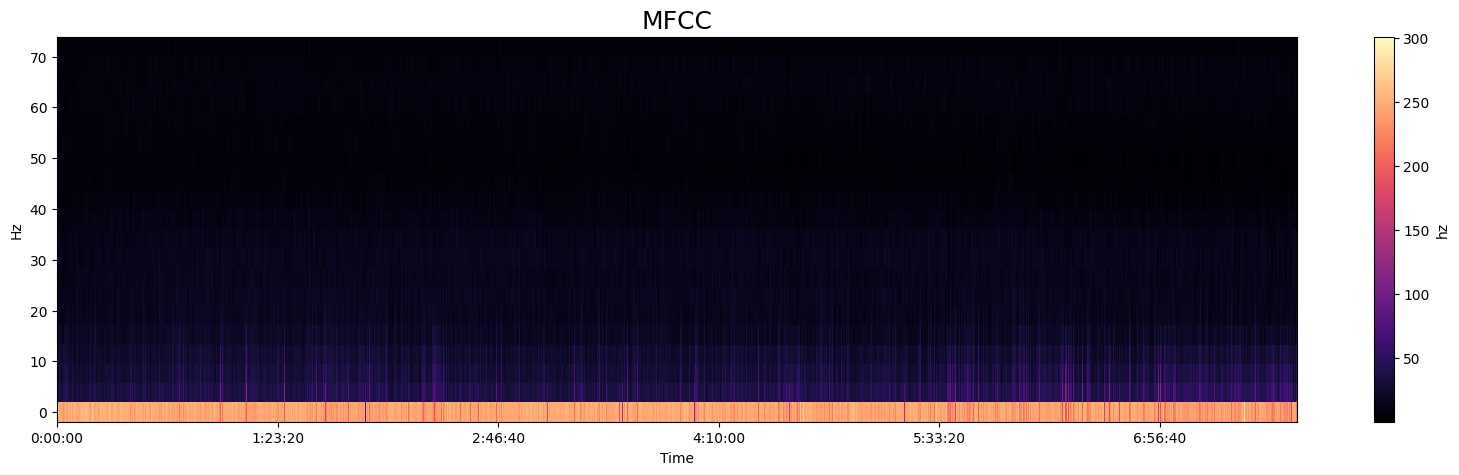

In [ ]:
plt.figure(figsize=(20, 5))
librosa.display.specshow(np.abs(merged_df["mfcc"][0]), x_axis='time',
                         y_axis = "hz", sr=144, cmap= "magma")
plt.colorbar(label = "hz")
plt.title("MFCC", fontdict=dict(size=18))
plt.show()

We will also visualize the waveform to look at the peaks of amiplitudes (https://librosa.org/doc/main/generated/librosa.display.waveshow.html).

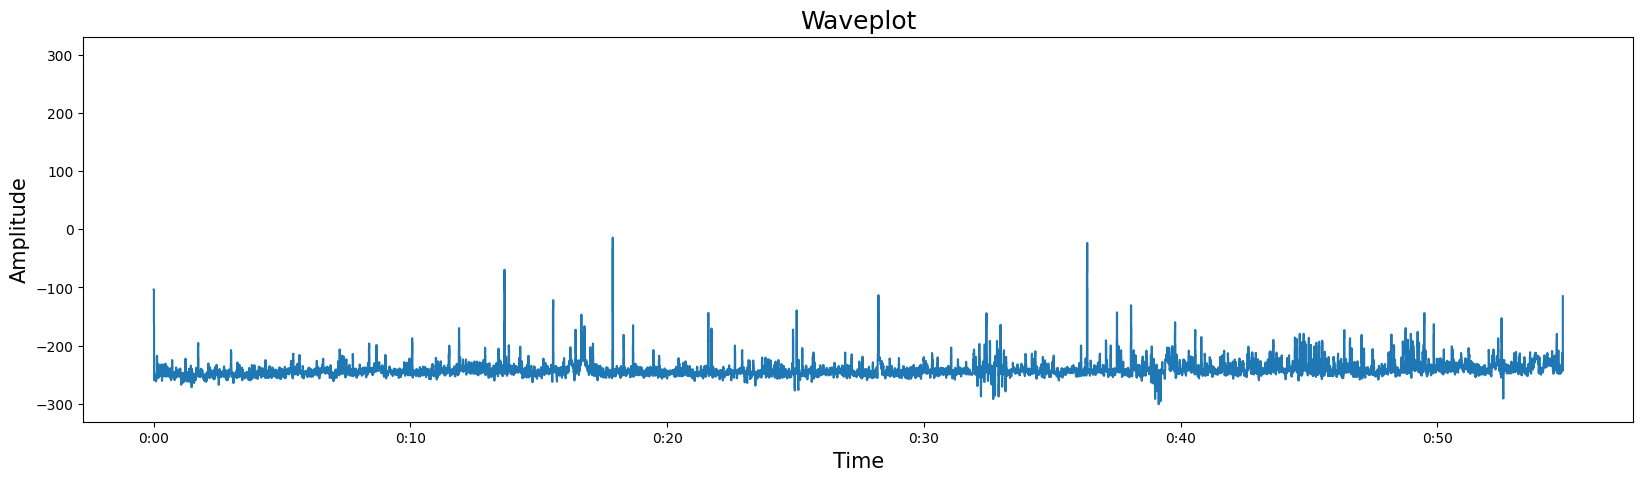

In [ ]:
plt.figure(figsize=(20, 5))
librosa.display.waveshow(merged_df["mfcc"][0], sr = 144)
plt.title("Waveplot", fontdict=dict(size=18))
plt.xlabel("Time", fontdict=dict(size=15))
plt.ylabel("Amplitude", fontdict=dict(size=15))
plt.show()

## Training Image Classification Neural Networks

### Dataset

We create a custom dataframe object for the mfcc or the melspectrogram.

In [ ]:
class AudioDataset(Dataset):
    def __init__(self, audio_data, labels, transform=None):
        self.audio_data = audio_data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.audio_data)

    def __getitem__(self, idx):
        # Load mel spectrogram
        mel_spectrogram = np.dstack([self.audio_data[idx], self.audio_data[idx], self.audio_data[idx]])

        # Apply transforms if specified
        if self.transform:
            mel_spectrogram = self.transform(mel_spectrogram)

        label = self.labels[idx]

        return mel_spectrogram, label

# Define transform to convert numpy arrays to torch tensors and normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Match input size expected by the model
    transforms.Normalize(mean=[0.5], std=[0.5])
])

First we split the dataframe into train and validation set.

In [ ]:
train_df = merged_df.sample(frac=0.8, random_state=42).reset_index(drop=True)
val_df = merged_df.drop(train_df.index).reset_index(drop=True)

In [ ]:
# Instantiate the dataset
dataset_train = AudioDataset(audio_data=train_df["mel_spectrogram"], labels=train_df["Sleep Quality"], transform=transform)
dataset_val = AudioDataset(audio_data=val_df["mel_spectrogram"], labels=val_df["Sleep Quality"], transform=transform)

# Create a DataLoader
data_loader = DataLoader(dataset_train, batch_size=1, shuffle=True)
data_loader_val = DataLoader(dataset_val, batch_size=1, shuffle=True)

In [ ]:
# Load a pretrained model from timm
model = timm.create_model('resnet18', pretrained=True)
model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

It is important to note that we are doing a regression task, therefore we need to change the last layer to have only one output feature.

### Model loading and training

In [ ]:
# Modify the model's classifier for regression
num_ftrs = model.fc.in_features
# Modify the last layer for regression
model.fc = nn.Linear(num_ftrs, 1)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
# Define loss and optimizer
criterion = .nn.HuberLoss(reduction='mean', delta=1.0)
optimizer = optim.Adam(model.parameters(), lr=1e-5)
# Set number of epochs
epochs = 10

In [ ]:
# Training loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    train_loss = 0.0
    val_loss = 0.0

    # Iterate over the training data
    for inputs, labels in data_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs).squeeze()  # Get predictions
        loss = criterion(outputs, labels.float())

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation for validation
        for inputs, labels in data_loader_val:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels.float())
            val_loss += loss.item()

    # Print the losses for this epoch
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss / len(data_loader)}, Validation Loss: {val_loss / len(data_loader_val)}")

Epoch 1/10, Train Loss: 0.003222457838959751, Validation Loss: 0.3033558251336217
Epoch 2/10, Train Loss: 0.0006498419609689184, Validation Loss: 0.28820072673261166
Epoch 3/10, Train Loss: 0.00011350702306174298, Validation Loss: 0.31819134671241045
Epoch 4/10, Train Loss: 3.758764866574893e-05, Validation Loss: 0.229422012809664
Epoch 5/10, Train Loss: 2.6617812197097615e-05, Validation Loss: 0.2410071245394647
Epoch 6/10, Train Loss: 2.2374589179700402e-05, Validation Loss: 0.31696505937725306
Epoch 7/10, Train Loss: 2.2255301576260915e-05, Validation Loss: 0.3433229848742485
Epoch 8/10, Train Loss: 1.557710481622602e-05, Validation Loss: 0.2502808878198266
Epoch 9/10, Train Loss: 1.3024330150438839e-05, Validation Loss: 0.32708535250276327
Epoch 10/10, Train Loss: 2.0767021839655325e-05, Validation Loss: 0.2674090638756752


In [ ]:
# Ensure the model is in evaluation mode
model.eval()

# Perform inference
predictions = []
with torch.no_grad():  # Disable gradient computation for inference
    for inputs, labels in data_loader_val:
        # Move data to device
        mel_spectrogram = inputs.to(device)

        # Forward pass
        output = model(mel_spectrogram)

        # Store the prediction
        predictions.append((output.item(), labels))  # Convert to Python number

# Print the predictions
for i, pred in enumerate(predictions):
    print(f"Prediction for audio {i}: {pred[0]}  Actual value for audio {i}: {pred[1].item()}")

Prediction for audio 0: 0.2995135188102722  Actual value for audio 0: 0.86
Prediction for audio 1: 0.24287264049053192  Actual value for audio 1: 0.5
Prediction for audio 2: 0.32033032178878784  Actual value for audio 2: 0.7
Prediction for audio 3: 0.2989402413368225  Actual value for audio 3: 0.91
Prediction for audio 4: 0.23748140037059784  Actual value for audio 4: 0.7
Prediction for audio 5: 0.24752478301525116  Actual value for audio 5: 0.88
Prediction for audio 6: 0.3019981384277344  Actual value for audio 6: 0.86
Prediction for audio 7: 0.41772300004959106  Actual value for audio 7: 0.98


In [ ]:
predictions

AttributeError: 'list' object has no attribute 'T'

### Testing

In [ ]:
feature_extractor = ASTFeatureExtractor()

In [ ]:
# Load and preprocess audio data
def load_and_preprocess_data_nn(data_dir, subsets, target_shape=(128, 128)):
    data = []
    labels = []
    filenames = []
    signals = []
    waveforms = []
    audio_dir = data_dir
    for i, subset in enumerate(subsets):
      subset_dir = os.path.join(audio_dir, subset)
      for filename in os.listdir(subset_dir):
        filenames.append(filename)
        if filename.endswith('.wav'):
            file_path = os.path.join(subset_dir, filename)
            print(file_path)
            waveform, sampling_rate = torchaudio.load(file_path)
            waveform = waveform.squeeze().numpy()

            print(waveform.shape)

            inputs = feature_extractor(waveform, sampling_rate=16000, padding="max_length", return_tensors="pt")
            input_values = inputs.input_values
            print(input_values.shape)

            waveforms.append(input_values)
            audio_data, sample_rate = librosa.load(file_path, sr=None)
            # Perform preprocessing (e.g., convert to Mel spectrogram and resize)
            audio_signal = librosa.feature.mfcc(y=audio_data, sr=sample_rate)
            mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
            signals.append(audio_signal)
            data.append(mel_spectrogram)
            labels.append(i)
    return data, np.array(labels), np.array(filenames), signals, waveforms

In [ ]:
data_dir = './data'
subsets = ['behrad']
audio_files, labels, filenames, signals, waveforms = load_and_preprocess_data_nn(data_dir = data_dir, subsets = subsets , target_shape=(128, 128))

./data/behrad/behrad_142Hz_1729733764243.wav
(4046780,)
torch.Size([1, 1024, 128])
./data/behrad/behrad_142Hz_1730426561089.wav
(3578312,)
torch.Size([1, 1024, 128])
./data/behrad/behrad_142Hz_1729994749595.wav
(4415588,)
torch.Size([1, 1024, 128])
./data/behrad/behrad_142Hz_1730598993365.wav
(3559186,)
torch.Size([1, 1024, 128])
./data/behrad/behrad_142Hz_1730341004221.wav
(3769170,)
torch.Size([1, 1024, 128])
./data/behrad/behrad_142Hz_1729904937567.wav
(3846064,)
torch.Size([1, 1024, 128])
./data/behrad/behrad_142Hz_1729820420488.wav
(3573998,)
torch.Size([1, 1024, 128])
./data/behrad/behrad_142Hz_1730169214846.wav
(4082500,)
torch.Size([1, 1024, 128])
./data/behrad/behrad_142Hz_1730770930651.wav
(4504808,)
torch.Size([1, 1024, 128])
./data/behrad/behrad_142Hz_1730513248148.wav
(4030670,)
torch.Size([1, 1024, 128])


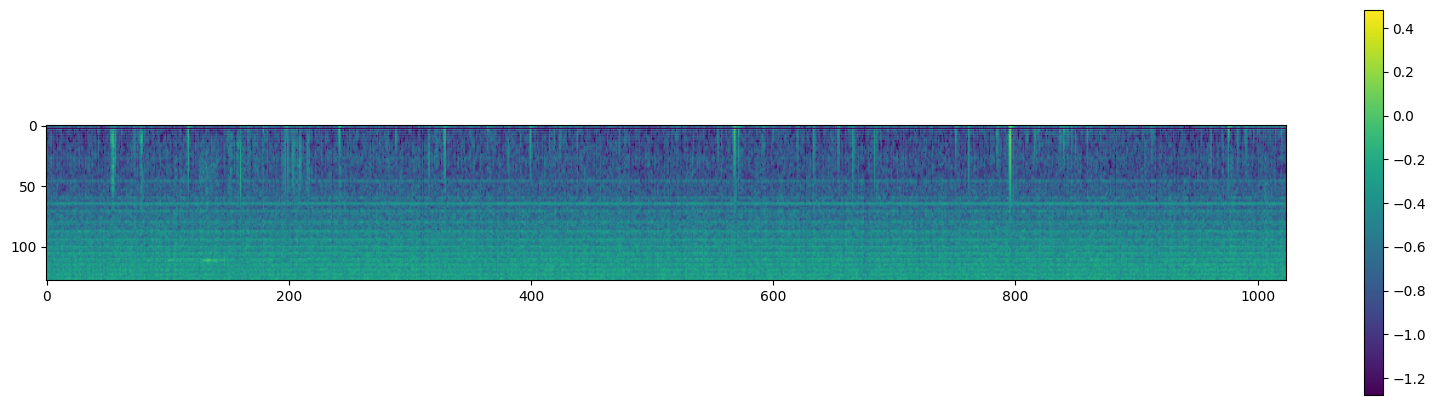

In [ ]:
plt.figure(figsize=(20, 5))
imgplot = plt.imshow(waveforms[0].mT.squeeze() )
plt.colorbar()
plt.show()